### creating a fit many gaussians to an image function

Seperately fit amplitudes, locations, etc. to create a good guess and then do a total fit

Maxima finding is based on the answer to this question:  
https://stackoverflow.com/questions/9111711/get-coordinates-of-local-maxima-in-2d-array-above-certain-value

In [1]:
import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt

In [5]:
from fitters.Gaussian import arb_2d_sum

In [74]:
from importlib import reload

In [75]:
reload(arb_2d_sum)

<module 'fitters.Gaussian.arb_2d_sum' from 'C:\\Users\\Regal-Lab\\Code\\Data-Analysis-Code\\fitters\\Gaussian\\arb_2d_sum.py'>

In [12]:
from matplotlib.pyplot import *
%matplotlib inline

In [235]:
import scipy.optimize as opt

In [217]:
def findImageMaxima(im, neighborhood_size=20, threshold=1):
    data_max = filters.maximum_filter(im, neighborhood_size)
    maxima = (im == data_max)
    data_min = filters.minimum_filter(im, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0
    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        y.append(y_center)
    print('Found ' + str(len(x)) + ' Maxima.')
    return [p for p in zip([int(x_) for x_ in x],[int(y_) for y_ in y])]


In [245]:
def fitManyGaussianImage(im, numGauss, neighborhood_size=20, threshold=1, direct=True, widthGuess=1):
    """
    Maxima finding is based on the answer to this question:
    https://stackoverflow.com/questions/9111711/get-coordinates-of-local-maxima-in-2d-array-above-certain-value
    """
    maximaLocs = findImageMaxima(im, neighborhood_size=neighborhood_size, threshold=threshold)
    if len(maximaLocs) != numGauss:
        raise ValueError("ERROR: didn't find the right number of maxima!")
    guess = [min(im.flatten())]
    for loc in maximaLocs:
        guess += [im[loc[1],loc[0]], loc[0], loc[1], widthGuess, widthGuess]
    xpts = np.arange(len(im[0]))
    ypts = np.arange(len(im))
    X,Y = np.meshgrid(xpts,ypts)
    zpts = arb_2d_sum.f((X,Y), *guess).reshape(X.shape)
    f, ax = subplots(1,5,figsize=(20,10))
    ax[0].imshow(im)
    ax[0].set_title('Orig')
    ax[1].imshow(zpts)
    ax[1].set_title('Guess')
    ax[2].imshow(im-zpts)
    ax[2].set_title('Guess-Diff')
    optParam, optCov = opt.curve_fit(arb_2d_sum.f, (X,Y), im.flatten(), p0=guess)
    zpts_fit = arb_2d_sum.f((X,Y), *optParam).reshape(X.shape)
    ax[3].imshow(zpts_fit)
    ax[3].set_title('Fit')
    ax[4].imshow(im-zpts_fit)
    ax[4].set_title('Fit-Diff')
    return optParam

Found 9 Maxima.


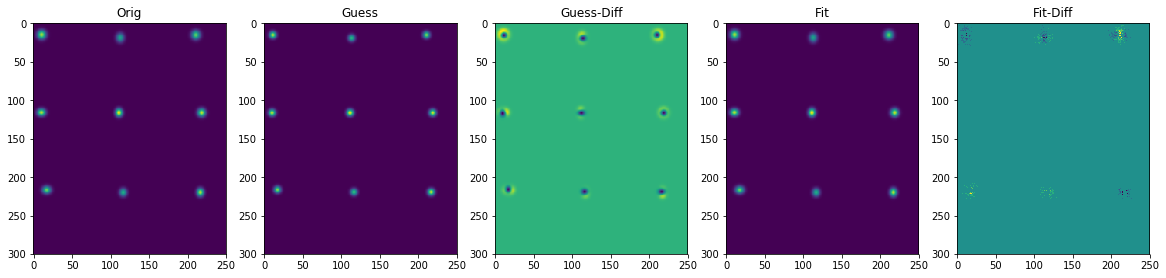

In [239]:
fitManyGaussianImage(zpts,9, widthGuess=3.0)